# This notebook is derived from :
https://www.kaggle.com/code/tanishqjazz/user-engagement-prediction-screentime-forecasting/notebook

Please upvote that notebook if you liked this notebook since they deserve all the credit!

## The benchmark MAE in that NB was 0.93 - we will try to get a lower MAE than that NB with just 10 lines of code.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                    cross_val_score)

# metrics
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error)
from sklearn.metrics import make_scorer

print('Done, All the required modules are imported')

Done, All the required modules are imported


We will be using LazyTransformer. But What is LazyTransformer?
<a href="https://ibb.co/VJnd8j7"><img src="https://i.ibb.co/DzcNnVx/lazytransformer.jpg" alt="lazytransformer" border="0"></a>

# Data Loading

In [2]:
# loading data
customer = pd.read_csv('../input/mobile-usage-time-prediction/customers.csv', delimiter = ',', encoding = 'utf-8')
pings = pd.read_csv('../input/mobile-usage-time-prediction/pings.csv', delimiter = ',', encoding = 'utf-8')
test_df = pd.read_csv('../input/mobile-usage-time-prediction/test.csv', delimiter = ',', encoding = 'utf-8')
print(customer.shape, pings.shape)
customer.head()

(2500, 4) (50528701, 2)


id gender  age  number_of_kids
0  979863   MALE   26               2
1  780123   MALE   60               2
2  614848   MALE   45               4
3  775046   MALE   62               3
4  991601   MALE   23               0

In [3]:
### Notice that the only info we have is the time stamp of each customer
pings.head()

id   timestamp
0  899313  1496278800
1  373017  1496278800
2  798984  1496278800
3  245966  1496278800
4  689783  1496278800

## Let's look at the test data: we need online hours by user_id and date

In [4]:
test_df.head()

id      date  online_hours
0  979863  28/06/17             7
1  979863  27/06/17             9
2  979863  26/06/17             9
3  979863  25/06/17            10
4  979863  24/06/17             9

# We will borrow a few feature engg steps from the previous notebook 

In [5]:
import re
from scipy import stats
from random import randint
from datetime import datetime
###  There is a lot of duplicates of user_id and timestamp calculation ##
pings = pings.sort_values(by = ['id','timestamp']).reset_index(drop=True)
# temp_ping_df = pings.copy()
pings.drop_duplicates(inplace = True)
pings['timestamp_decode'] = pings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

## EXTRACTING DATE from timestamp column
pings['date'] = pings['timestamp_decode'].dt.date
pings.head()

id   timestamp    timestamp_decode        date
0  111556  1496279340 2017-06-01 01:09:00  2017-06-01
1  111556  1496279355 2017-06-01 01:09:15  2017-06-01
2  111556  1496279370 2017-06-01 01:09:30  2017-06-01
3  111556  1496279400 2017-06-01 01:10:00  2017-06-01
4  111556  1496279430 2017-06-01 01:10:30  2017-06-01

In [6]:
# EXTRACTING HOURS SPENT ONLINE from the timestamp for each uer 
pings['online_hours'] = (pings.groupby(by=['id','date'])['timestamp'].diff())/(60*60)
pings['online_hours']  =  pings['online_hours'].apply(lambda x: x if x< (2/60) else (2/60))

# MAKING DATA CAPABLE FOR MERGING
pings.fillna(0,inplace = True)
pings.head()

id   timestamp    timestamp_decode        date  online_hours
0  111556  1496279340 2017-06-01 01:09:00  2017-06-01      0.033333
1  111556  1496279355 2017-06-01 01:09:15  2017-06-01      0.004167
2  111556  1496279370 2017-06-01 01:09:30  2017-06-01      0.004167
3  111556  1496279400 2017-06-01 01:10:00  2017-06-01      0.008333
4  111556  1496279430 2017-06-01 01:10:30  2017-06-01      0.008333

# **# Creating the training data requires HAVING SAME "ID" & "DATE" GROUPED TOGETHER AND THEIR SUM OF ONLINE HOURS STORED #**

In [7]:
train_df= (pings.groupby(by = ['id','date'])['online_hours'].sum()).reset_index()
#rounding off hours into integers
train_df['online_hours'] = round(train_df['online_hours'],1) 
print('Done')
train_df.head()

Done


id        date  online_hours
0  111556  2017-06-01           2.2
1  111556  2017-06-02           2.5
2  111556  2017-06-05           4.7
3  111556  2017-06-06           3.2
4  111556  2017-06-07           2.7

# We will install the SuloRegressor and LazyTransformer from featurewiz library

In [8]:
!pip install featurewiz 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
  Attempting uninstall: category-encoders
    Found existing installation: category-encoders 2.5.0
    Uninstalling category-encoders-2.5.0:
      Successfully uninstalled category-encoders-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markup

In [9]:
from lazytransform import LazyTransformer, SuloRegressor

Imported LazyTransformer v1.8. 



In [10]:
# Okay everything ready, now lets see the min, max dates for train and test datasets Then move with concatination of both dataframes...
import time
start_time = time.time()
print('Minimum date and Maximum date for train dataset: {},{}'.format(train_df.date.min(), train_df.date.max()))
print('Minimum date and Maximum date for test dataset: {},{}'.format(test_df.date.min(), test_df.date.max()))
print('Time taken: %0.0f seconds' %(time.time()-start_time))

Minimum date and Maximum date for train dataset: 2017-06-01,2017-06-22
Minimum date and Maximum date for test dataset: 22/06/17,28/06/17
Time taken: 0 seconds


# We need to add customer data to both train_df and test_df


In [11]:
# MERGING THE CUSTOMER DATABASE WITH THE TRAIN and TEST DATABASE
temp_df = pd.merge(left = train_df, right = customer, on = 'id', how = 'left')
print(temp_df.shape)
temp_df.head()

(41738, 6)


id        date  online_hours  gender  age  number_of_kids
0  111556  2017-06-01           2.2  FEMALE   49               4
1  111556  2017-06-02           2.5  FEMALE   49               4
2  111556  2017-06-05           4.7  FEMALE   49               4
3  111556  2017-06-06           3.2  FEMALE   49               4
4  111556  2017-06-07           2.7  FEMALE   49               4

In [12]:
test_df.head(1)

id      date  online_hours
0  979863  28/06/17             7

## Before we send in the train and test data, we need to convert the date-time into pandas date-time

In [13]:
### we need to align train and test dates 
temp_df['date'] = pd.to_datetime(temp_df['date'], format='%Y-%m-%d')
test_df['date'] = pd.to_datetime(test_df['date'], format='%d/%m/%y')
test_df.head()

id       date  online_hours
0  979863 2017-06-28             7
1  979863 2017-06-27             9
2  979863 2017-06-26             9
3  979863 2017-06-25            10
4  979863 2017-06-24             9

In [14]:
test_df = pd.merge(left = test_df, right = customer, on = 'id', how = 'left')
print(test_df.shape)
test_df.head()

(17542, 6)


id       date  online_hours gender  age  number_of_kids
0  979863 2017-06-28             7   MALE   26               2
1  979863 2017-06-27             9   MALE   26               2
2  979863 2017-06-26             9   MALE   26               2
3  979863 2017-06-25            10   MALE   26               2
4  979863 2017-06-24             9   MALE   26               2

# We need to split the data into X_train and X_test using TimeSeriesSplit to avoid data leakage
(Random split of train data will result in data leakage - so you must avoid it)

In [15]:
### solving model like a typical regression problem without any considerations and feature engineering
target = 'online_hours'
X = temp_df.drop(columns = target)
y = temp_df[target]

In [16]:
from featurewiz import FeatureWiz

Imported featurewiz 0.4.5. Use the new scikit-learn syntax:
        wiz = FeatureWiz(feature_engg = '', nrows=None,
        		category_encoders="auto", add_missing=False, verbose=0)
        X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features     



In [17]:
# Remove warnings from output
import warnings 
warnings.filterwarnings('ignore')

In [18]:
from lazytransform import print_regression_model_stats

In [19]:
test_len = int(len(y)*0.1)
test_len

4173

TRAIN: [    0     1     2 ... 29216 29217 29218] TEST: [29219 29220 29221 ... 33389 33390 33391]
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (29219, 5)
Beware: Potentially creates 6 features (some will be dropped due to zero variance)
    3 features grouped by date for aggregates ['mean']
    3 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (29219, 11). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (29219, 30)
#### Single_

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 16%


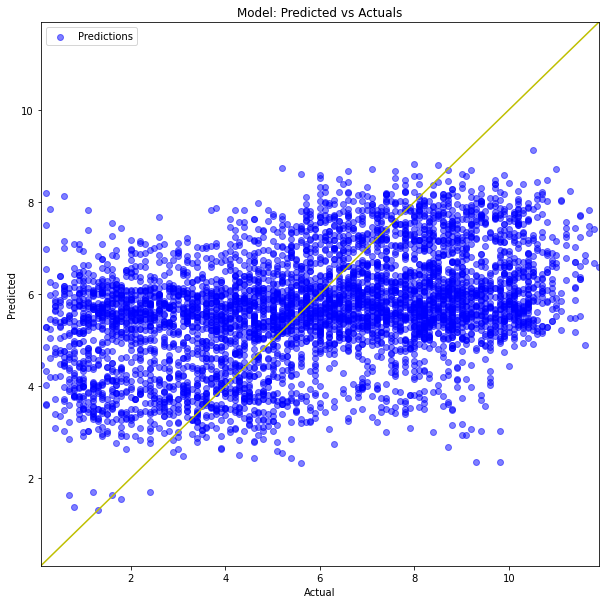

k-fold training:  20%|██        | 1/5 [00:06<00:24,  6.22s/it]

    R-Squared = 15%


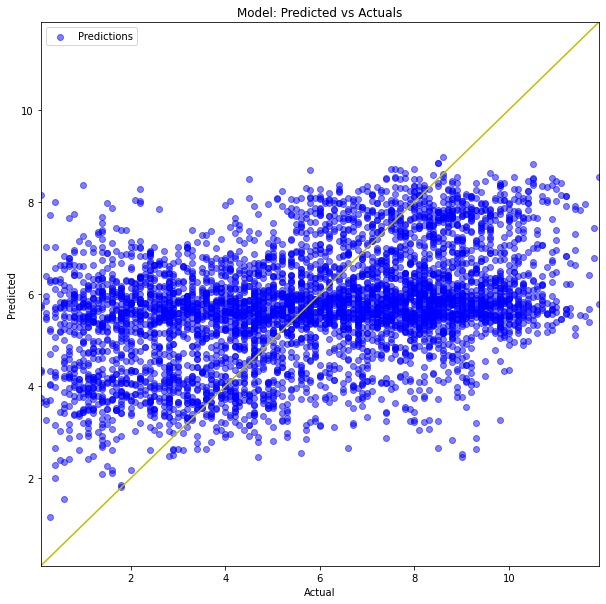

k-fold training:  40%|████      | 2/5 [00:06<00:08,  2.80s/it]

    R-Squared = 18%


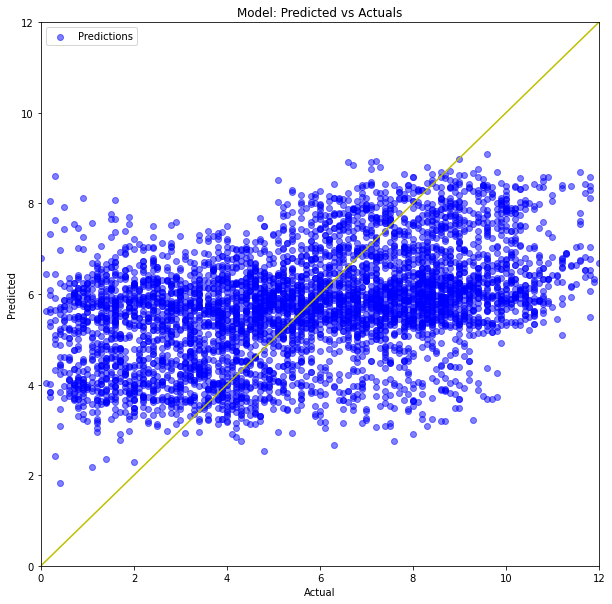

k-fold training:  60%|██████    | 3/5 [00:07<00:03,  1.72s/it]

    R-Squared = 19%


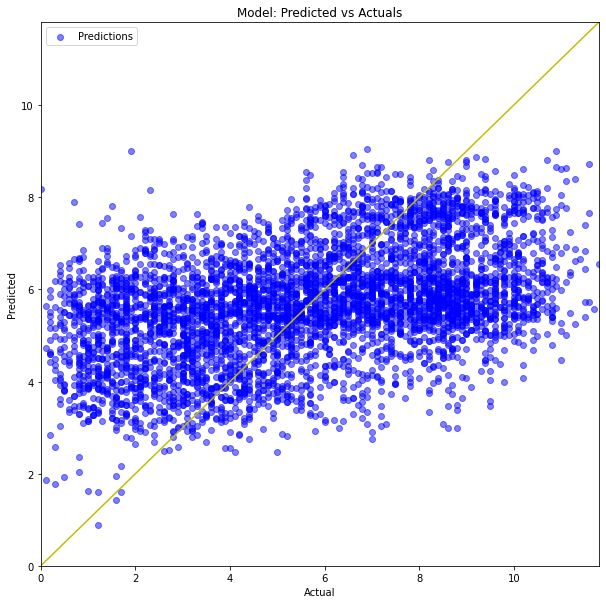

k-fold training:  80%|████████  | 4/5 [00:07<00:01,  1.87s/it]


Final RMSE of 5-estimator SuloRegressor: 2.578
    Final Normalized RMSE: 91.7%
Time Taken: 7 (seconds)
    RMSE = 2.538
    Norm RMSE = 90%
    MAE = 2.120
    WAPE = 39%, Bias = -2%
    MAPE = 7212%
    R-Squared = 19%


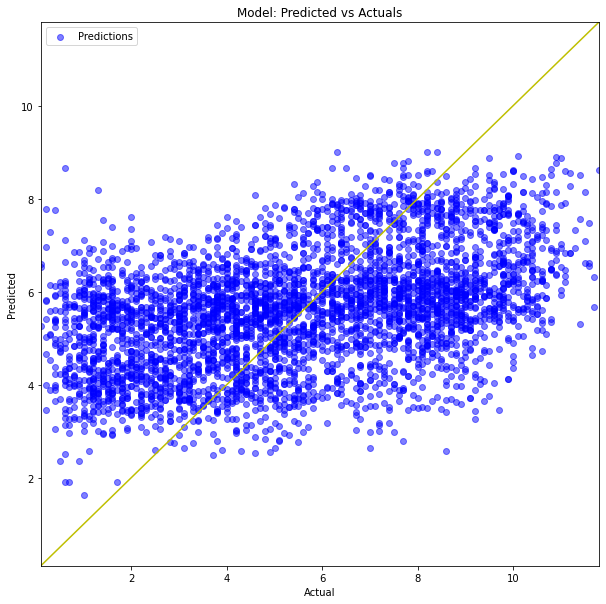

RMSE from all folds:  [2.537832016858053]
Average RMSE of all folds:  2.537832016858053
TRAIN: [    0     1     2 ... 33389 33390 33391] TEST: [33392 33393 33394 ... 37562 37563 37564]
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (33392, 5)
Beware: Potentially creates 6 features (some will be dropped due to zero variance)
    3 features grouped by date for aggregates ['mean']
    3 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (33392, 11). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to tr

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 15%


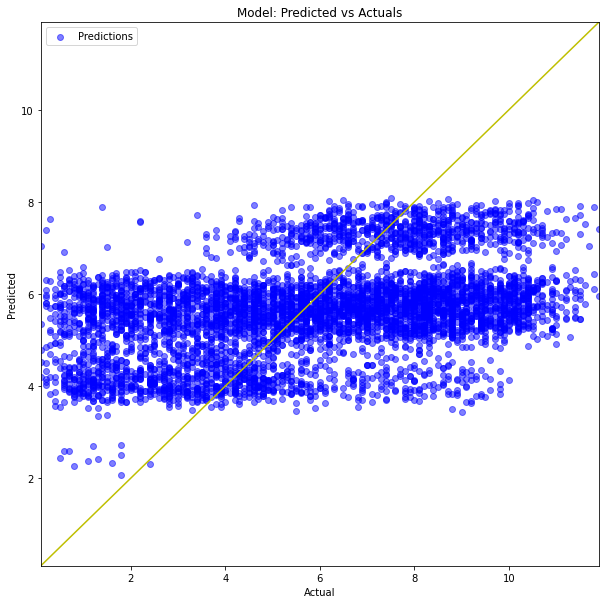

k-fold training:  20%|██        | 1/5 [00:02<00:10,  2.59s/it]

    R-Squared = 16%


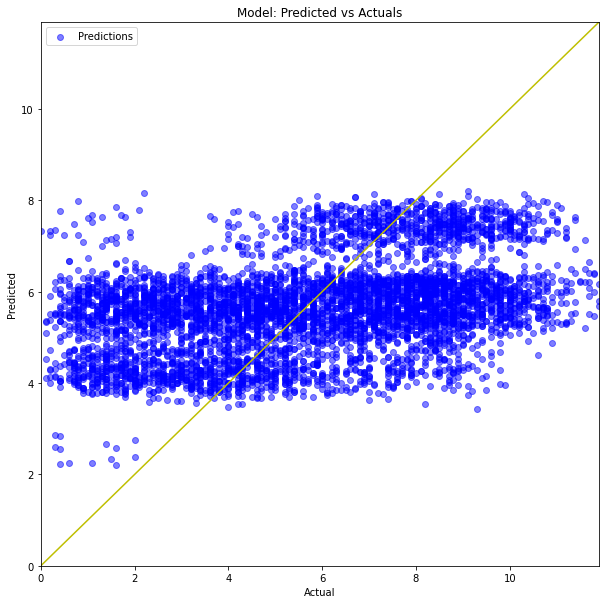

k-fold training:  40%|████      | 2/5 [00:03<00:03,  1.33s/it]

    R-Squared = 17%


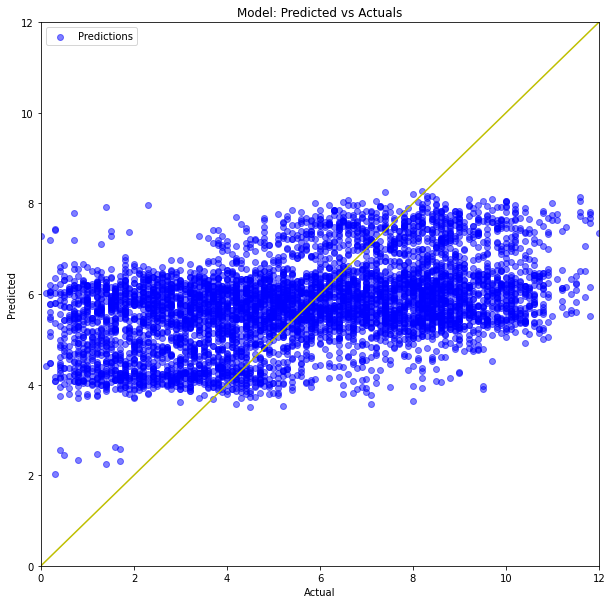

k-fold training:  60%|██████    | 3/5 [00:03<00:01,  1.07it/s]

    R-Squared = 15%


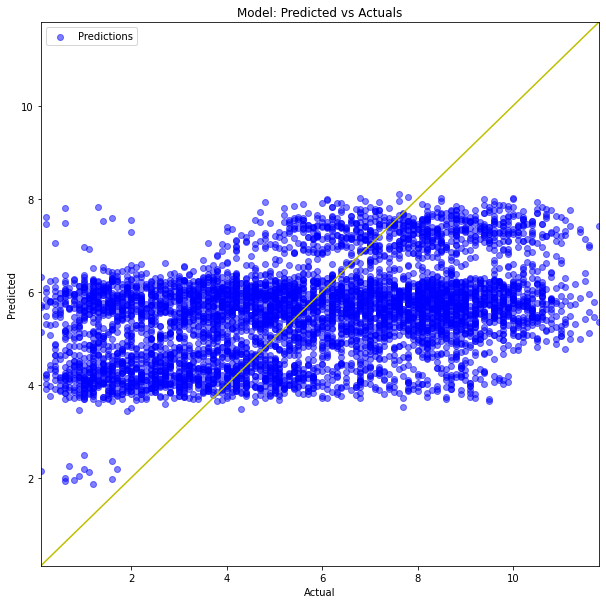

k-fold training:  80%|████████  | 4/5 [00:04<00:01,  1.00s/it]


Final RMSE of 5-estimator SuloRegressor: 2.593
    Final Normalized RMSE: 91.4%
Time Taken: 4 (seconds)
    RMSE = 2.600
    Norm RMSE = 92%
    MAE = 2.160
    WAPE = 42%, Bias = -5%
    MAPE = 8158%
    R-Squared = 15%


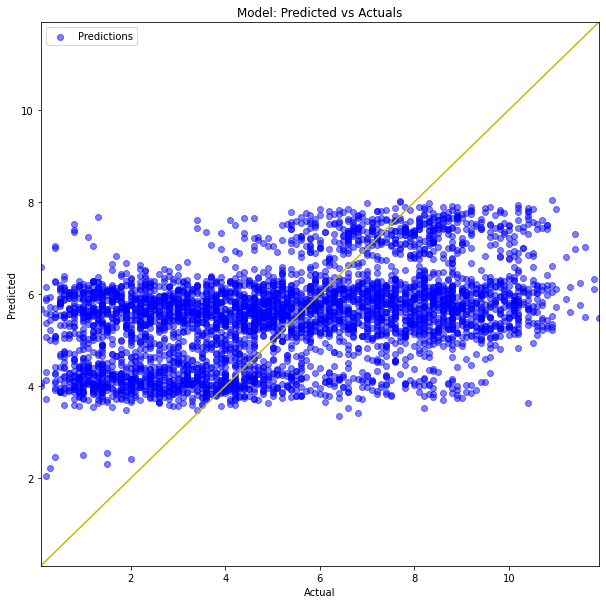

RMSE from all folds:  [2.537832016858053, 2.599990480979159]
Average RMSE of all folds:  2.568911248918606
TRAIN: [    0     1     2 ... 37562 37563 37564] TEST: [37565 37566 37567 ... 41735 41736 41737]
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (37565, 5)
Beware: Potentially creates 6 features (some will be dropped due to zero variance)
    3 features grouped by date for aggregates ['mean']
    3 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (37565, 11). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
 

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 12%


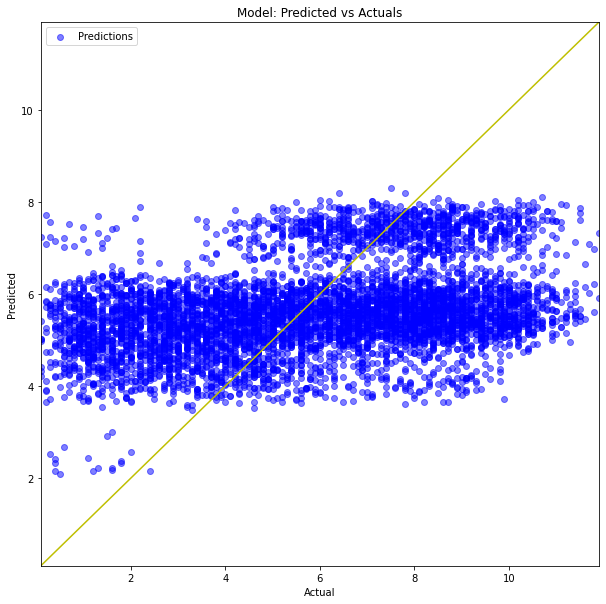

k-fold training:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

    R-Squared = 15%


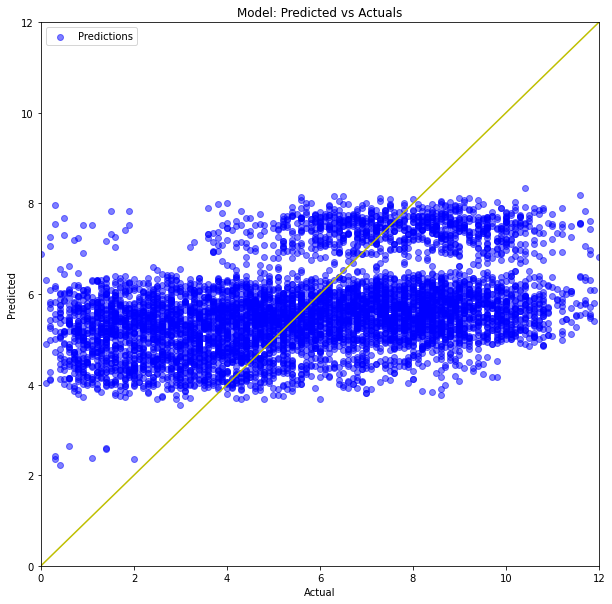

k-fold training:  40%|████      | 2/5 [00:03<00:04,  1.51s/it]

    R-Squared = 14%


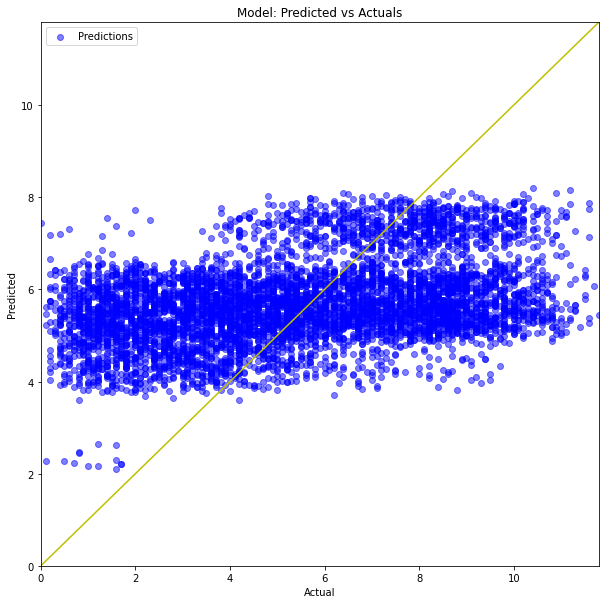

k-fold training:  60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

    R-Squared = 13%


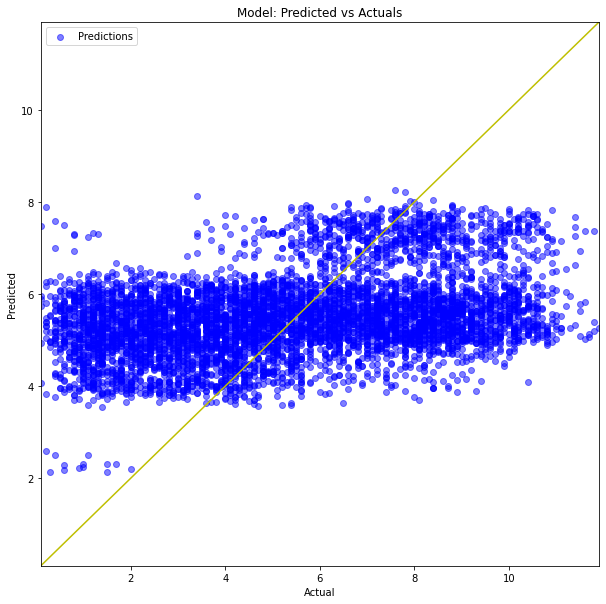

k-fold training:  80%|████████  | 4/5 [00:04<00:01,  1.12s/it]


Final RMSE of 5-estimator SuloRegressor: 2.629
    Final Normalized RMSE: 92.5%
Time Taken: 4 (seconds)
    RMSE = 2.568
    Norm RMSE = 94%
    MAE = 2.136
    WAPE = 37%, Bias = 1%
    No MAPE available since zeroes in actuals
    R-Squared = 12%


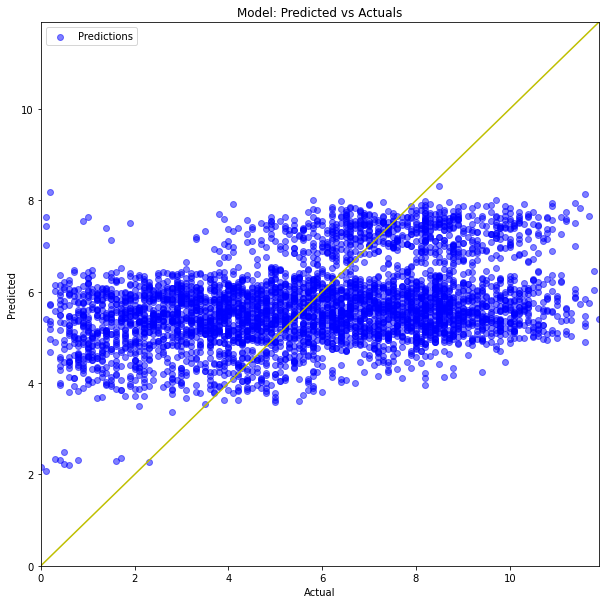

RMSE from all folds:  [2.537832016858053, 2.599990480979159, 2.568150669228708]
Average RMSE of all folds:  2.5686577223553066


In [21]:
tscv = TimeSeriesSplit(n_splits=3, test_size=test_len)
rmse_folds1 = []
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train1, X_test1 = X.loc[train_index], X.loc[test_index]
    y_train1, y_test1 = y.loc[train_index], y.loc[test_index]
    wiz = FeatureWiz(corr_limit=0.9, verbose=0, sep=',', header=0, 
                feature_engg='groupby', category_encoders='', 
                add_missing=False, nrows=None)
    X1_train, y1_train = wiz.fit_transform(X_train1, y_train1)    
    X1_test = wiz.transform(X_test1)
    sulo = SuloRegressor(time_series="sliding")
    sulo.fit(X1_train,y1_train)
    y_preds1 = sulo.predict(X1_test)
    rmse_folds1.append(print_regression_model_stats(y_test1, y_preds1, verbose=1))
    print('RMSE from all folds: ', rmse_folds1)
    print('Average RMSE of all folds: ', np.mean(rmse_folds1))

# The Sulo Model's RMSE of 2.57 is not comparable to the previous NB's RMSE since they randomized data split and hence had a data leak.

# Let's see if Adding Time Series lagged features helps the mode perform better

In [22]:
## preparing the training data
data2 = temp_df.copy()
data2.head()

id       date  online_hours  gender  age  number_of_kids
0  111556 2017-06-01           2.2  FEMALE   49               4
1  111556 2017-06-02           2.5  FEMALE   49               4
2  111556 2017-06-05           4.7  FEMALE   49               4
3  111556 2017-06-06           3.2  FEMALE   49               4
4  111556 2017-06-07           2.7  FEMALE   49               4

In [23]:
print('Minimum date and Maximum date for train dataset: {},{}'.format(data2.date.min(), data2.date.max()))
print('Minimum date and Maximum date for test dataset: {},{}'.format(test_df.date.min(), test_df.date.max()))

Minimum date and Maximum date for train dataset: 2017-06-01 00:00:00,2017-06-22 00:00:00
Minimum date and Maximum date for test dataset: 2017-06-22 00:00:00,2017-06-28 00:00:00


In [24]:
### we now need to use a second version of X and y
X2= data2.drop([target] , axis=1)
y2 = data2[target]
print(X2.shape, y2.shape)
X2.head()

(41738, 5) (41738,)


id       date  gender  age  number_of_kids
0  111556 2017-06-01  FEMALE   49               4
1  111556 2017-06-02  FEMALE   49               4
2  111556 2017-06-05  FEMALE   49               4
3  111556 2017-06-06  FEMALE   49               4
4  111556 2017-06-07  FEMALE   49               4

In [25]:
from featurewiz import TS_Lagging_Transformer

# we are now going to add Time Series lagging features and try Sulo again

In [26]:
test_len = int(len(y2)*0.1)
test_len

4173

TRAIN: [    0     1     2 ... 29216 29217 29218] TEST: [29219 29220 29221 ... 33389 33390 33391]
Train shape before =  (29219, 5)
Before adding lag column, shape of data set = (29219, 5)
After adding lag column, shape of data: (29219, 6)
Train shape after =  (29219, 6)
Test shape before =  (4173, 5)
After adding lag column, shape of data: (4173, 6)
Test shape after =  (4173, 6)
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (29219, 6)
Beware: Potentially creates 8 features (some will be dropped due to zero variance)
    4 features grouped by date for aggregates ['mean']
    4 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (29219, 14). Now we classify variables in

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 47%


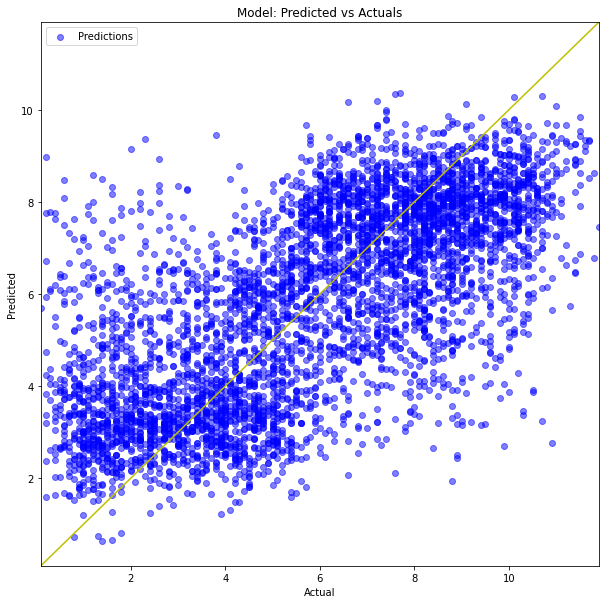

k-fold training:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]

    R-Squared = 42%


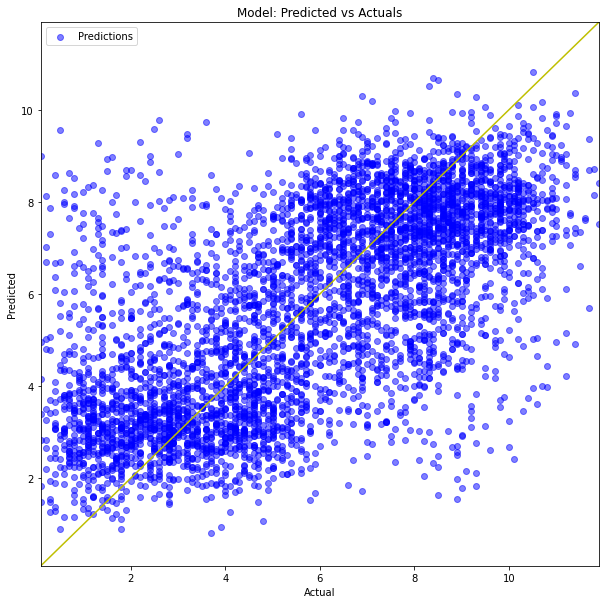

k-fold training:  40%|████      | 2/5 [00:05<00:07,  2.58s/it]

    R-Squared = 42%


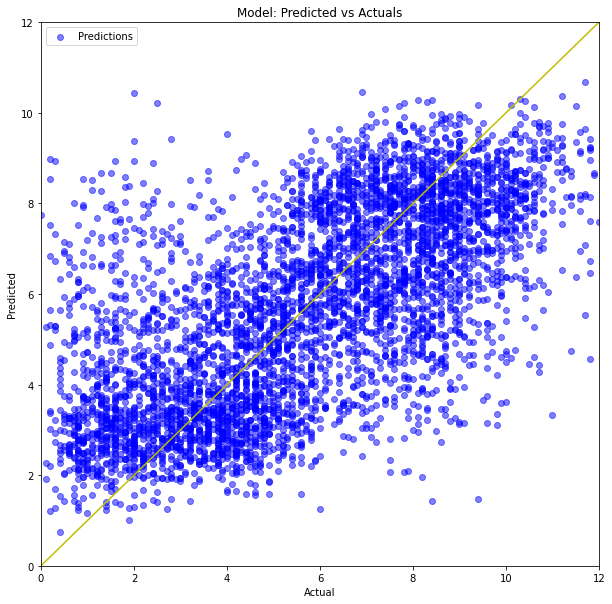

k-fold training:  60%|██████    | 3/5 [00:06<00:03,  1.73s/it]

    R-Squared = 46%


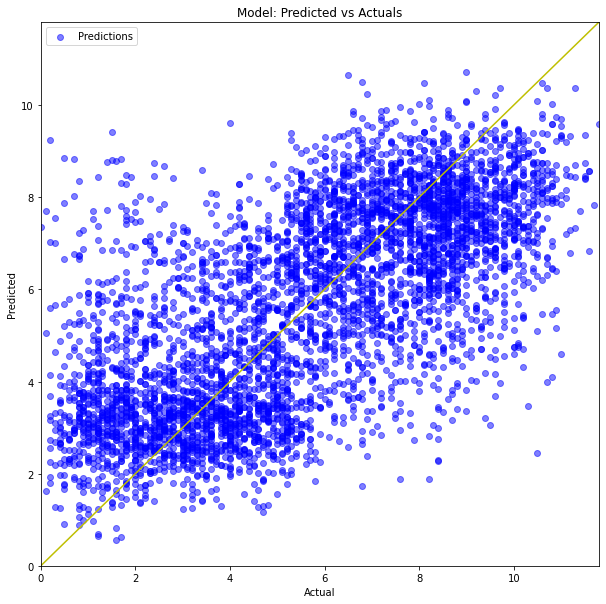

k-fold training:  80%|████████  | 4/5 [00:07<00:01,  1.84s/it]


Final RMSE of 5-estimator SuloRegressor: 2.112
    Final Normalized RMSE: 75.1%
Time Taken: 7 (seconds)
    RMSE = 2.712
    Norm RMSE = 96%
    MAE = 2.213
    WAPE = 40%, Bias = -1%
    MAPE = 7259%
    R-Squared = 8%


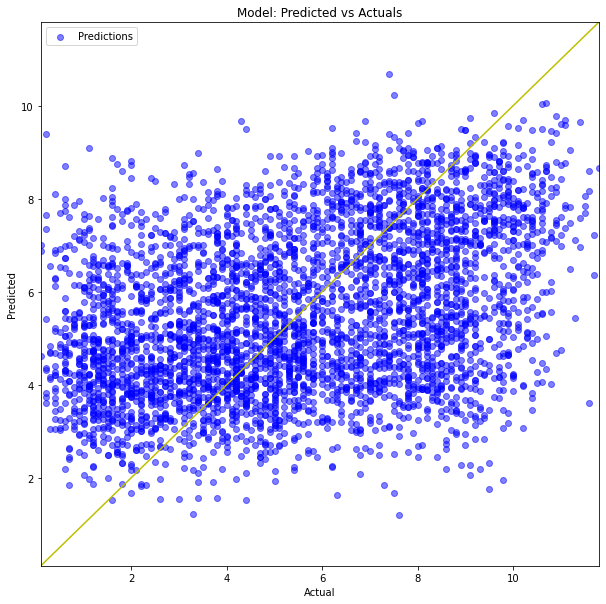

RMSE from all folds:  [2.712028470825648]
Average RMSE of all folds:  2.712028470825648
TRAIN: [    0     1     2 ... 33389 33390 33391] TEST: [33392 33393 33394 ... 37562 37563 37564]
Train shape before =  (33392, 5)
Before adding lag column, shape of data set = (33392, 5)
After adding lag column, shape of data: (33392, 6)
Train shape after =  (33392, 6)
Test shape before =  (4173, 5)
After adding lag column, shape of data: (4173, 6)
Test shape after =  (4173, 6)
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (33392, 6)
Beware: Potentially creates 8 features (some will be dropped due to zero variance)
    4 features grouped by date for aggregates ['mean']
    4 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_L

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 43%


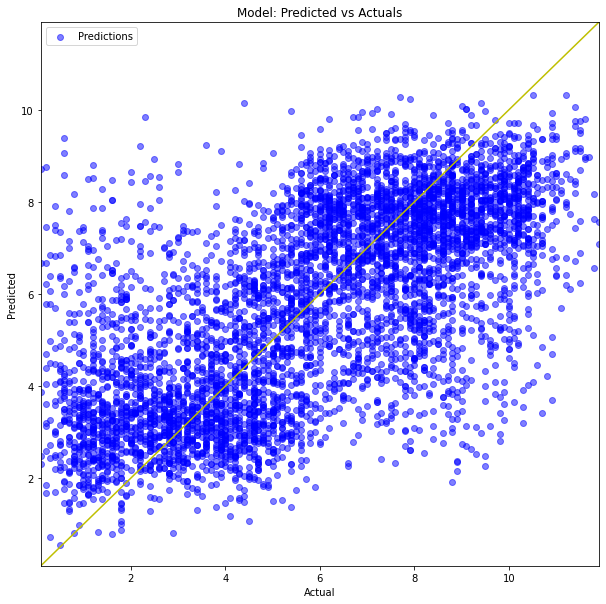

k-fold training:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

    R-Squared = 43%


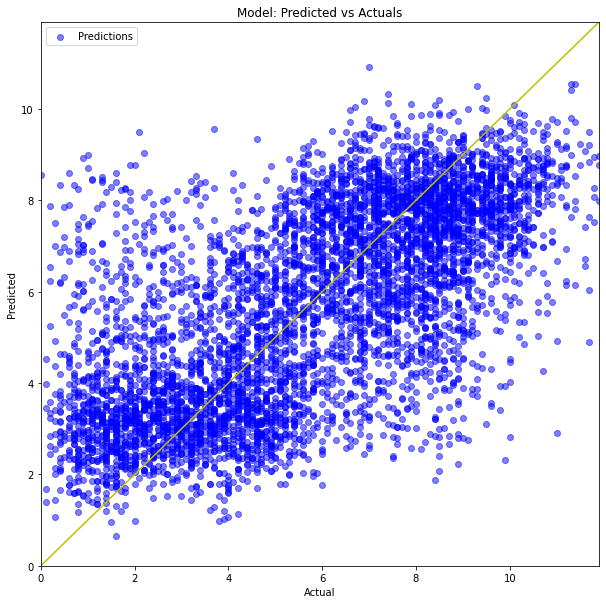

k-fold training:  40%|████      | 2/5 [00:03<00:05,  1.72s/it]

    R-Squared = 42%


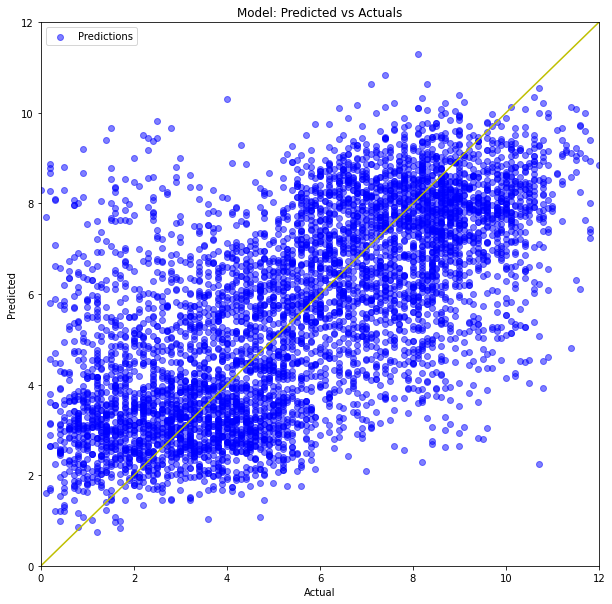

k-fold training:  60%|██████    | 3/5 [00:04<00:02,  1.24s/it]

    R-Squared = 46%


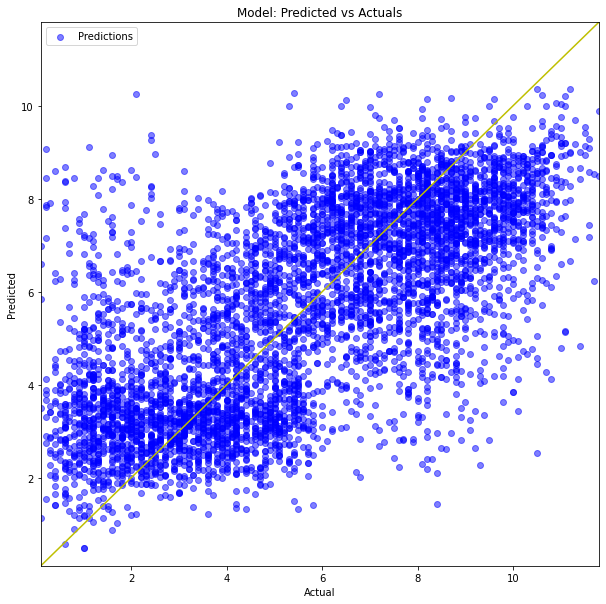

k-fold training:  80%|████████  | 4/5 [00:05<00:01,  1.31s/it]


Final RMSE of 5-estimator SuloRegressor: 2.122
    Final Normalized RMSE: 74.8%
Time Taken: 5 (seconds)
    RMSE = 2.891
    Norm RMSE = 102%
    MAE = 2.345
    WAPE = 45%, Bias = -1%
    MAPE = 8178%
    R-Squared = -5%


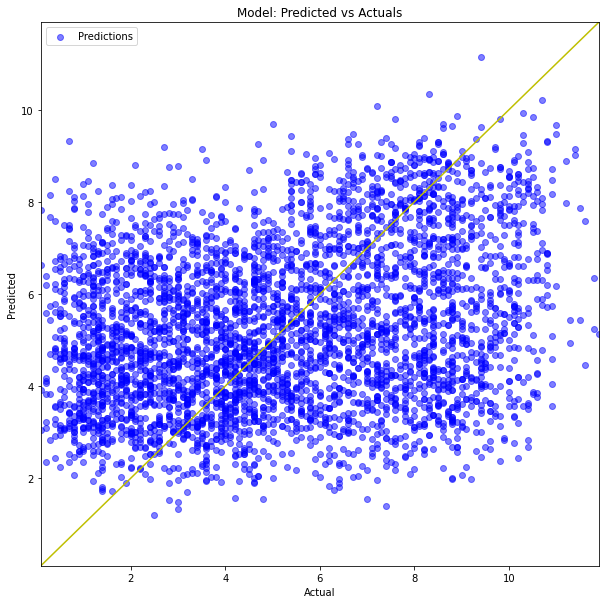

RMSE from all folds:  [2.712028470825648, 2.8906414761254786]
Average RMSE of all folds:  2.801334973475563
TRAIN: [    0     1     2 ... 37562 37563 37564] TEST: [37565 37566 37567 ... 41735 41736 41737]
Train shape before =  (37565, 5)
Before adding lag column, shape of data set = (37565, 5)
After adding lag column, shape of data: (37565, 6)
Train shape after =  (37565, 6)
Test shape before =  (4173, 5)
After adding lag column, shape of data: (4173, 6)
Test shape after =  (4173, 6)
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (37565, 6)
Beware: Potentially creates 8 features (some will be dropped due to zero variance)
    4 features grouped by date for aggregates ['mean']
    4 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to nume

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 43%


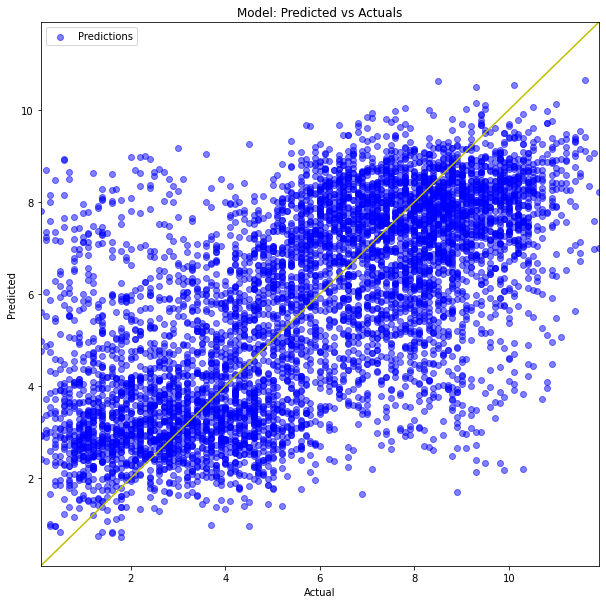

k-fold training:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

    R-Squared = 43%


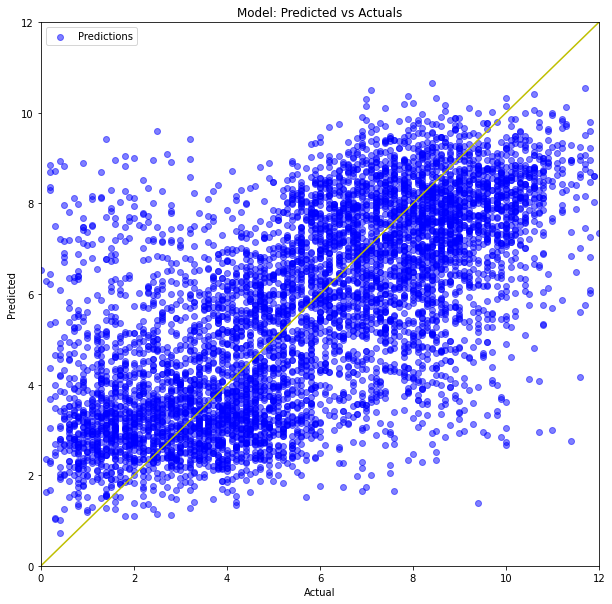

k-fold training:  40%|████      | 2/5 [00:04<00:05,  1.88s/it]

    R-Squared = 45%


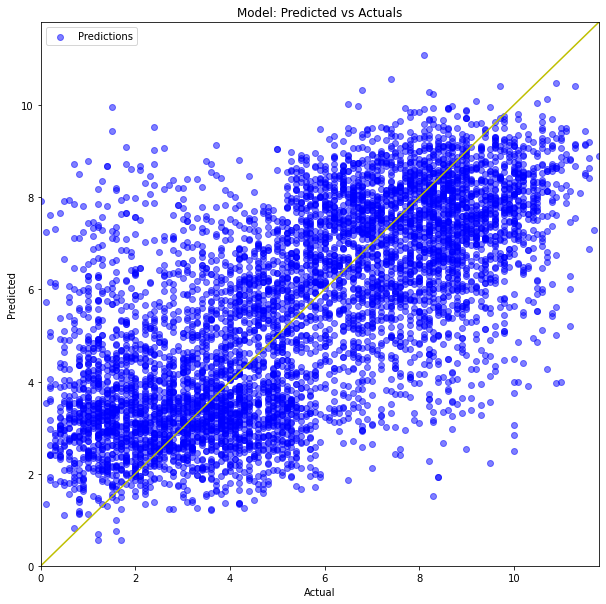

k-fold training:  60%|██████    | 3/5 [00:04<00:02,  1.36s/it]

    R-Squared = 45%


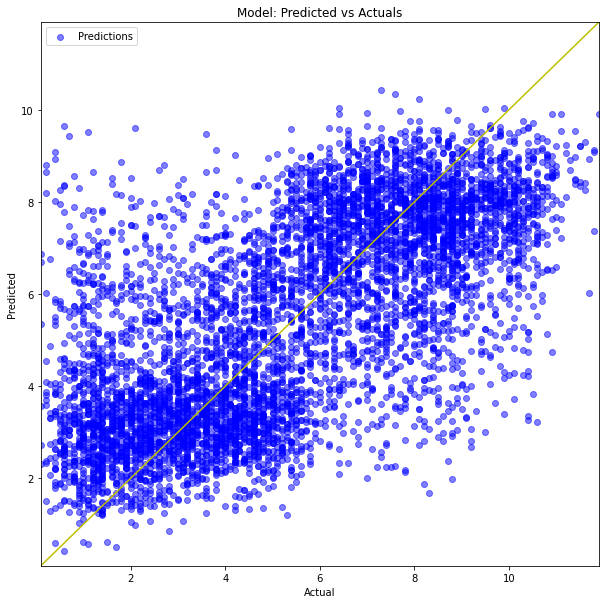

k-fold training:  80%|████████  | 4/5 [00:05<00:01,  1.42s/it]


Final RMSE of 5-estimator SuloRegressor: 2.110
    Final Normalized RMSE: 74.3%
Time Taken: 6 (seconds)
    RMSE = 2.708
    Norm RMSE = 99%
    MAE = 2.180
    WAPE = 38%, Bias = 0%
    No MAPE available since zeroes in actuals
    R-Squared = 2%


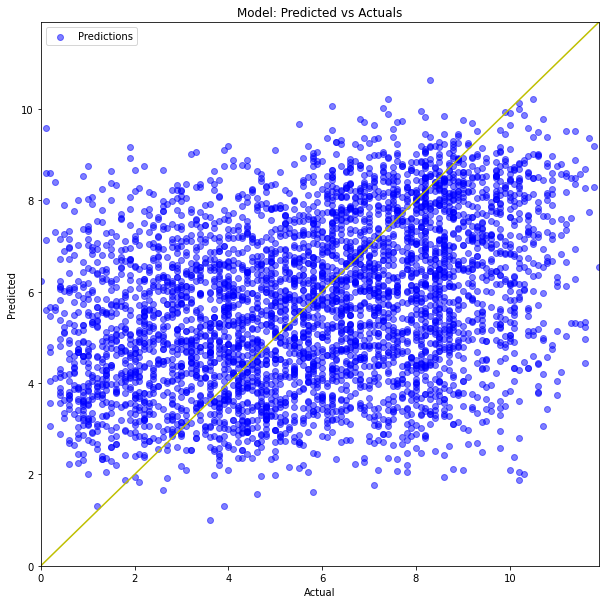

RMSE from all folds:  [2.712028470825648, 2.8906414761254786, 2.708047795161021]
Average RMSE of all folds:  2.7702392473707156


In [27]:
rmse_folds2 = []
tscv = TimeSeriesSplit(n_splits=3, test_size=test_len)
for train_index, test_index in tscv.split(X2):
    lagger = TS_Lagging_Transformer(lags=1, ts_column='date', 
                    hier_vars=['id','gender'], time_period='daily', verbose=0)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train2, X_test2 = X2.loc[train_index], X2.loc[test_index]
    y_train2, y_test2 = y2.loc[train_index], y2.loc[test_index]
    print('Train shape before = ', X_train2.shape)
    X_train2m = lagger.fit_transform(X_train2, y_train2)
    print('Train shape after = ', X_train2m.shape)
    print('Test shape before = ', X_test2.shape)
    X_test2m = lagger.transform(X_test2)
    print('Test shape after = ', X_test2m.shape)
    wiz = FeatureWiz(corr_limit=0.9, verbose=0, sep=',', header=0, 
                feature_engg='groupby', category_encoders='', 
                add_missing=False, nrows=None)
    X2_train, y2_train = wiz.fit_transform(X_train2m, y_train2)    
    X2_test = wiz.transform(X_test2m)
    model = SuloRegressor(time_series='sliding')
    model.fit(X2_train,y2_train)
    y_preds2 = model.predict(X2_test)
    rmse_folds2.append(print_regression_model_stats(y_test2, y_preds2, verbose=1))
    print('RMSE from all folds: ', rmse_folds2)
    print('Average RMSE of all folds: ', np.mean(rmse_folds2))

# The average RMSE of lagged model 2.76 is actually higher than regular model of 2.56 # ** So it appears to be slightly worse. Let's test it on test data

# **the error difference between Sulo model and prev NB's deep learning model is due to the data leakage in the deep learning model due to random splitting and cannot be compared **

## Now let's test the two models against the held out test data

In [29]:
models = [sulo, model]

In [31]:
preds = [x for x in test_df if x not in ['online_hours']]
len(preds)

5

Before adding lag column, shape of data set = (41738, 5)
After adding lag column, shape of data: (41738, 6)
After adding lag column, shape of data: (17542, 6)
featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (41738, 6)
Beware: Potentially creates 8 features (some will be dropped due to zero variance)
    4 features grouped by date for aggregates ['mean']
    4 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (41738, 14). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 43%


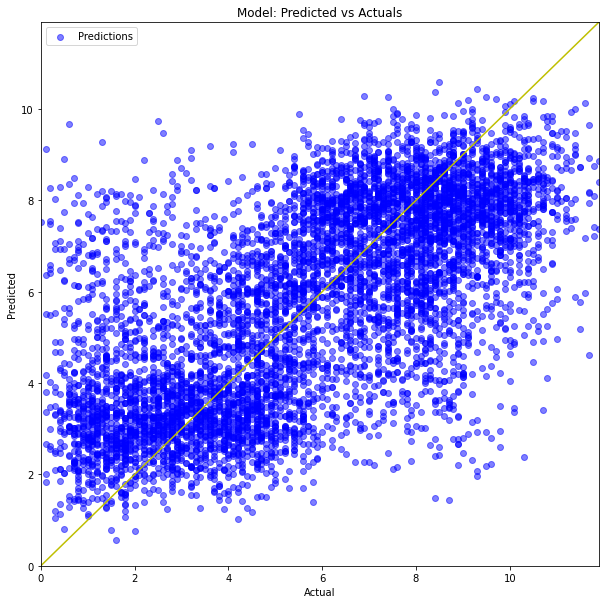

k-fold training:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]

    R-Squared = 43%


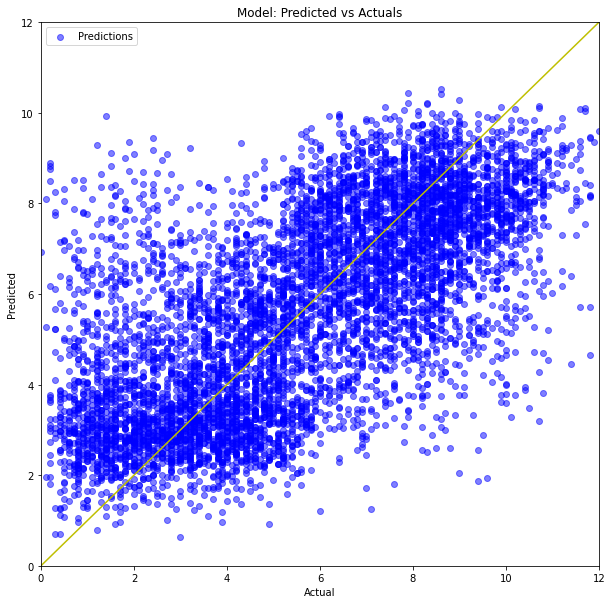

k-fold training:  40%|████      | 2/5 [00:06<00:08,  2.71s/it]

    R-Squared = 46%


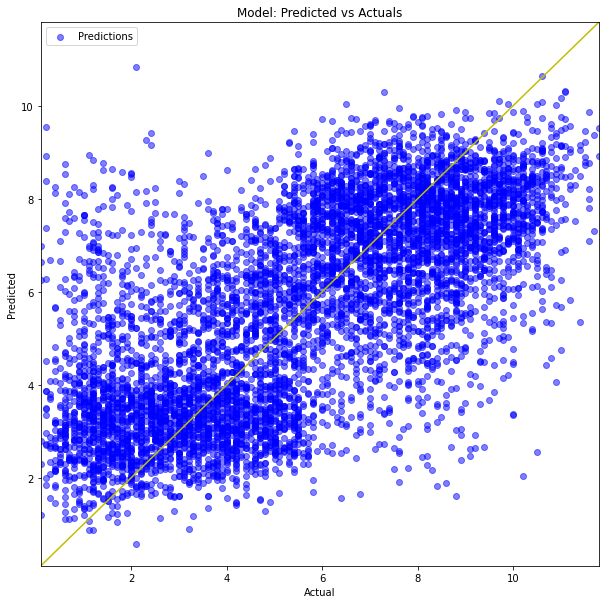

k-fold training:  60%|██████    | 3/5 [00:07<00:03,  1.84s/it]

    R-Squared = 45%


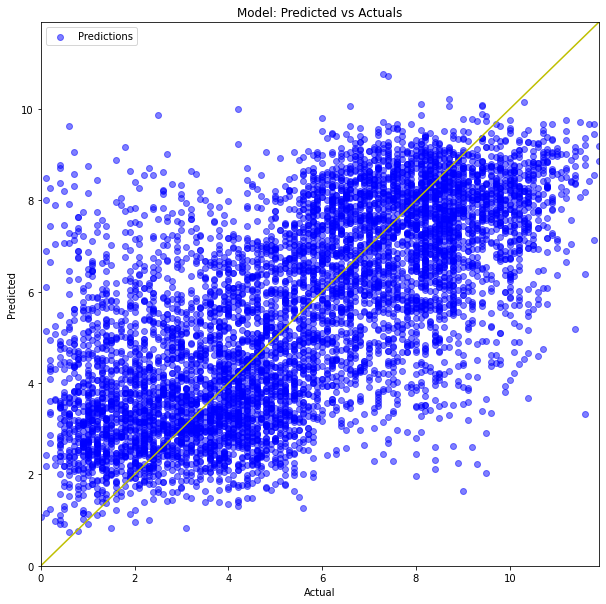

k-fold training:  80%|████████  | 4/5 [00:07<00:01,  1.95s/it]


Final RMSE of 5-estimator SuloRegressor: 2.100
    Final Normalized RMSE: 75.1%
Time Taken: 8 (seconds)
Lagged features model results:
    R-Squared = -20%


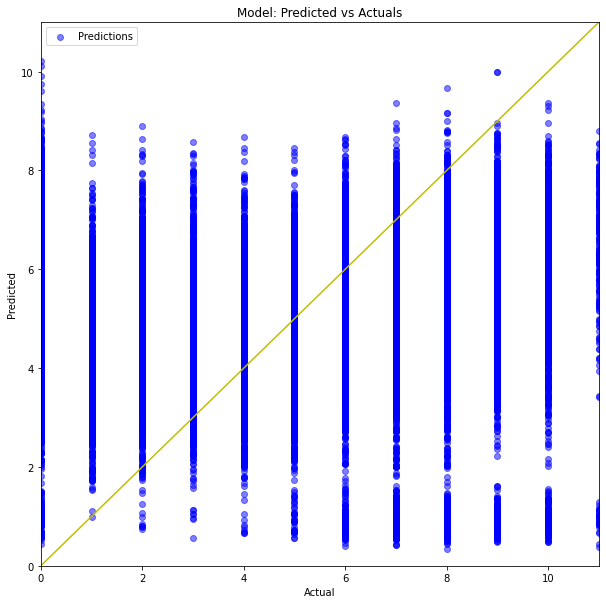

featurewiz is given 0.9 as correlation limit...
Loaded input data. Shape = (41738, 5)
Beware: Potentially creates 6 features (some will be dropped due to zero variance)
    3 features grouped by date for aggregates ['mean']
    3 features grouped by gender for aggregates ['mean']
No interactions created for categorical vars since no interactions feature engg specified
No target encoded features created since no target feature engg specified
    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (41738, 11). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (41738, 30)
#### Single_Label Regression problem ####
    Dropping 11 columns due to zero variance...
Starting SULOV with

k-fold training:   0%|          | 0/5 [00:00<?, ?it/s]

    R-Squared = 18%


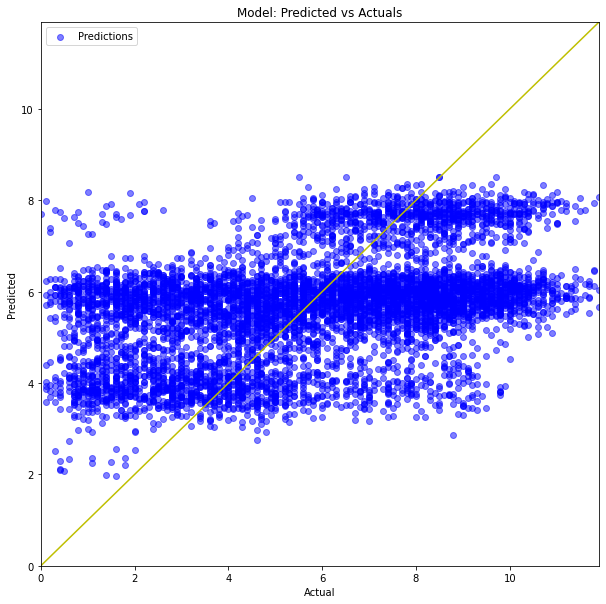

k-fold training:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

    R-Squared = 18%


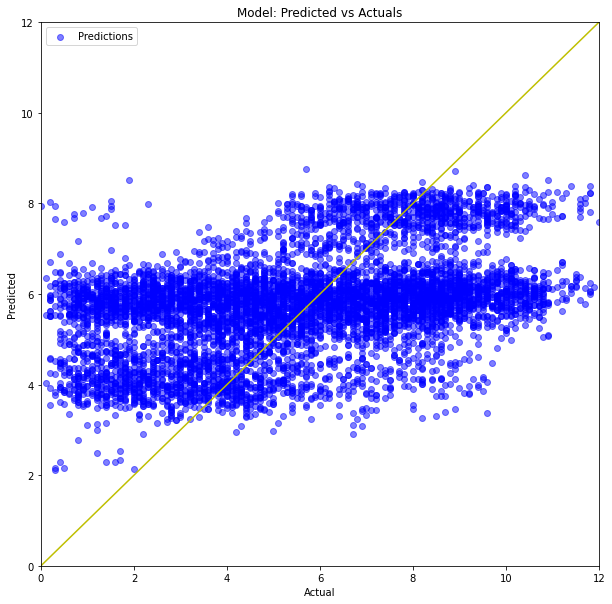

k-fold training:  40%|████      | 2/5 [00:03<00:04,  1.51s/it]

    R-Squared = 18%


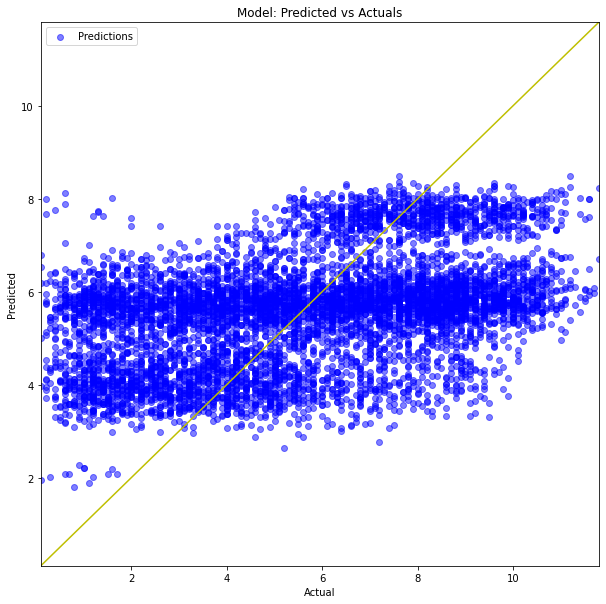

k-fold training:  60%|██████    | 3/5 [00:03<00:02,  1.05s/it]

    R-Squared = 19%


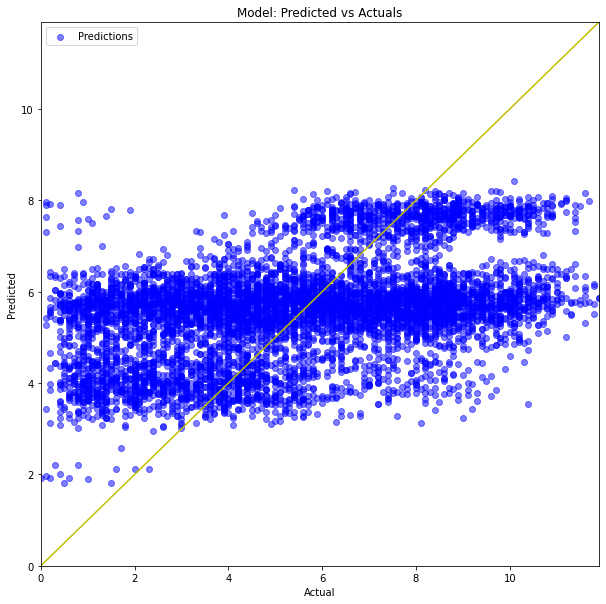

k-fold training:  80%|████████  | 4/5 [00:04<00:01,  1.11s/it]


Final RMSE of 5-estimator SuloRegressor: 2.542
    Final Normalized RMSE: 90.9%
Time Taken: 4 (seconds)
Regular features model results:
    R-Squared = -19%


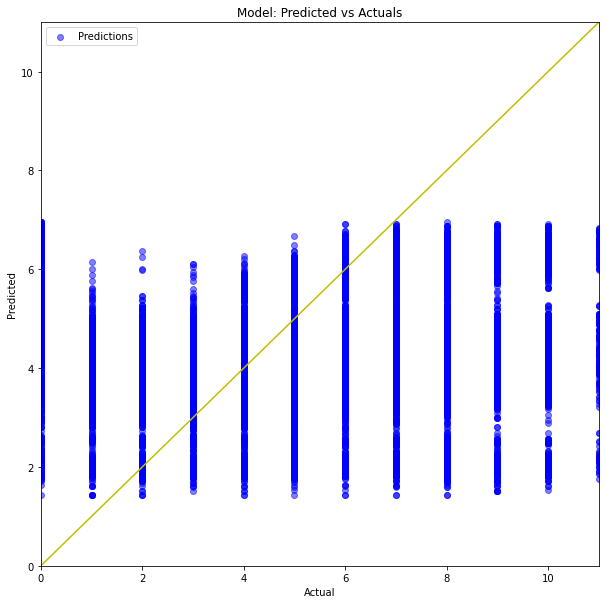

In [37]:
import copy
for i, each_model in enumerate(models):
    if i == 0:
        lagger = TS_Lagging_Transformer(lags=1, ts_column='date', 
                        hier_vars=['id','gender'], time_period='daily', verbose=0)
        X1 = lagger.fit_transform(X, y)
        test_1 = lagger.transform(test_df[preds])
    else:
        X1 = copy.deepcopy(X)
        test_1 = test_df[preds]
    wiz = FeatureWiz(corr_limit=0.9, verbose=0, sep=',', header=0, 
                feature_engg='groupby', category_encoders='', 
                add_missing=False, nrows=None)
    X2, y1 = wiz.fit_transform(X1, y)
    test_2 = wiz.transform(test_1)
    model = SuloRegressor(time_series='sliding')
    model.fit(X2, y1)
    y_preds1 = model.predict(test_2)
    if i == 0:
        print('Lagged features model results:')
        print_regression_model_stats(test_df['online_hours'], y_preds1)    
    else:
        print('Regular features model results:')
        print_regression_model_stats(test_df['online_hours'], y_preds1)    

* # The average RMSE of lagged 2.1 is actually less than the regular RMSE of 2.53. # ** So it appears that lagging is working on test data **.